In [39]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

from astropy.visualization import (SqrtStretch, ImageNormalize)
from copy import deepcopy
from scipy.ndimage import rotate
import matplotlib.patches as patches
from matplotlib.path import Path

from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# snap 1
size = 17
filts = ['g','r','i','z','y']
ps1 = sd.PS1_images(ra,dec,size,filts)

../scenes/ps1_funcs.py:183: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(ima) + 25 + 2.5*np.log10(im.header['EXPTIME'])
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


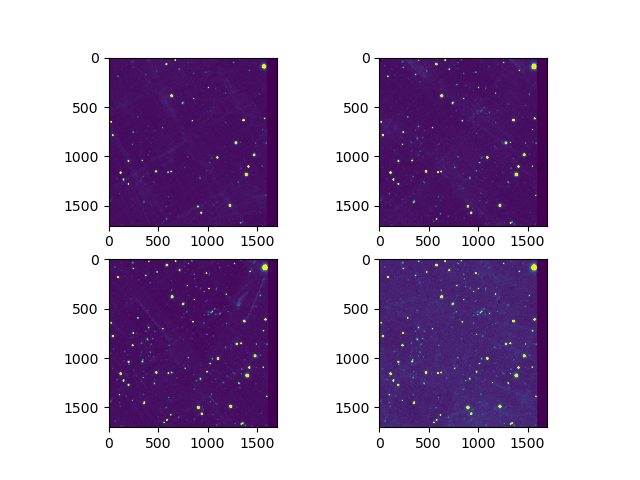

In [3]:
plt.figure()
plt.subplot(221)
plt.imshow(ps1['g'],vmin=0,vmax=1)
plt.subplot(222)
plt.imshow(ps1['r'],vmin=0,vmax=1)
plt.subplot(223)
plt.imshow(ps1['i'],vmin=0,vmax=1)
plt.subplot(224)
plt.imshow(ps1['z'],vmin=0,vmax=1)

In [3]:
def PS1_ap_phot(ps1):
    mags = {}
    for key in list(ps1.keys()):
        if len(key) == 1:
            bkg = np.nanmedian(ps1[key][580:630,620:680])
            mask = np.zeros_like(ps1[key]) > 0
            mask[630:670,630:670] = True
            #print(bkg*np.nansum(mask))
            s = np.nansum(ps1[key][mask])- np.nansum(mask)*bkg
            mags[key] = -2.5*np.log10(s) + 25 #+ 2.5*np.log10(ps1['exp'+key])
    return mags

In [4]:
PS1_ap_phot(ps1)

{'g': 20.575464026299358,
 'r': 20.520363936133503,
 'i': 20.6768307729034,
 'z': 19.705213750984836,
 'y': 18.717296744398784}

/Users/rridden/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


<IPython.core.display.Javascript object>


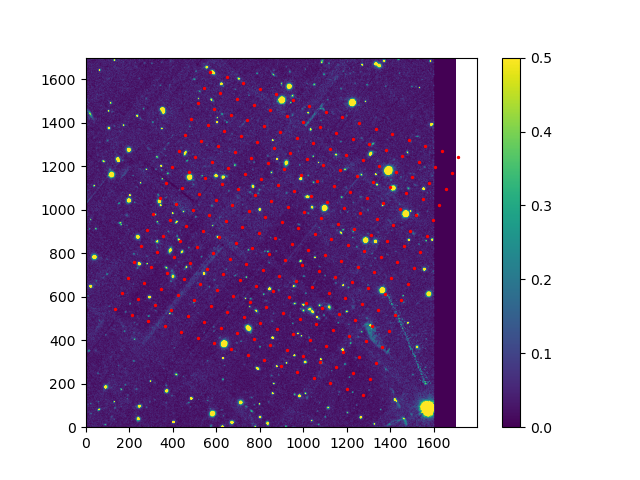

In [4]:
tpf = sd.Get_TESS(ra,dec,15)

tess_corners = sd.Get_TESS_corners(tpf, ps1['wcs'])
plt.figure()
#plt.subplot(projection=wcs)
plt.imshow(ps1['i'],origin='lower',vmax=.5)
plt.colorbar()
plt.scatter(tess_corners[0,:,:].flatten(),tess_corners[1,:,:].flatten(),c='r',s=2)

<IPython.core.display.Javascript object>


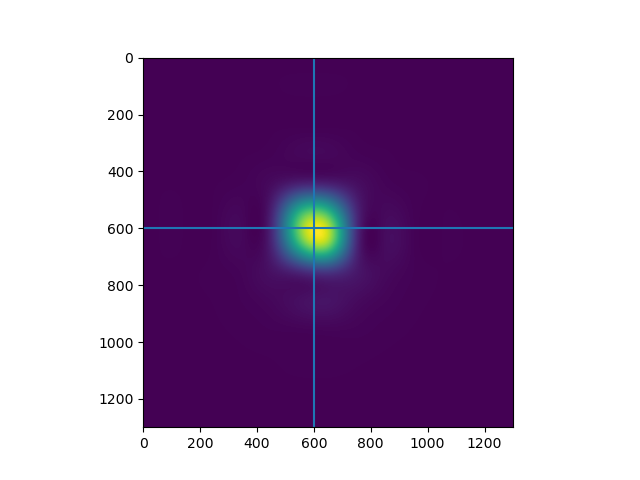

In [6]:
prf = sd.Interp_PRF(tpf.row,tpf.column,tpf.camera,tpf.ccd,100)
plt.figure()
plt.imshow(prf)
plt.axvline(600)
plt.axhline(600)

In [5]:
ps1conv = sd.Convolve_PS1(ps1,tpf,tess_corners)
down = sd.Regrid_PS1(ps1conv,tess_corners)
comp = sd.PS1_tess_comp(down)
frac = sd.PS1_tess_frac(down)

<IPython.core.display.Javascript object>


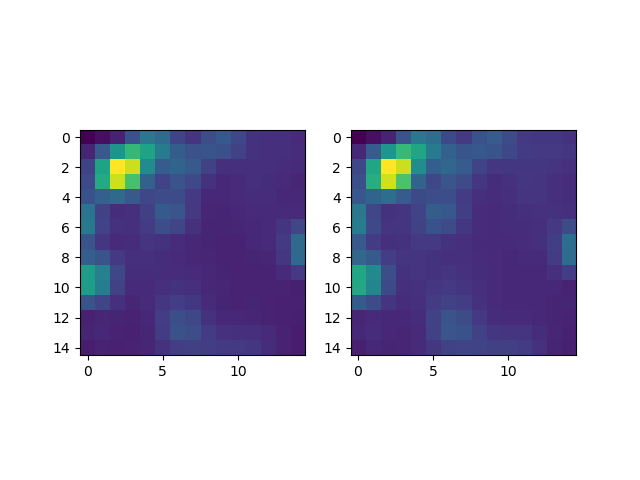

In [6]:
plt.figure()
plt.subplot(121)
plt.imshow(comp)
plt.subplot(122)
plt.imshow(frac)

In [57]:
def fit_psf(c,ps1,tess,corners):
    print(c)
    sig = c[0]
    zp = c[1]
    #a = [c[2],c[3]]
    g = sd.Gaussian2D(1300,FWHM=sig) #* skewed(a)
    p = sd.signal.fftconvolve(ps1, g, mode='same')
    p = sd.Regrid_PS(p,corners).T
    p = np.log10(p) + zp
    t = np.log10(tess) #+ 20.44
    ind = t > 10
    
    res = np.nansum(abs(t[ind]-p[ind]))
    print('res ',res)
    return res

    

In [58]:
com = sd.PS1_tess_comp(ps1)
tess = tpf.flux[100] - np.percentile(tpf.flux[100],1)
c = [137,-6]#,0,0]
r = minimize(fit_psf,c,args=(com,t,tess_corners),method='Nelder-Mead')

../scenes/ps1_funcs.py:112: RuntimeWarning: divide by zero encountered in true_divide
  cz*ps1['z'] + cy*ps1['y'])*(ps1['g']/ps1['i'])**cp)
../scenes/ps1_funcs.py:112: RuntimeWarning: invalid value encountered in true_divide
  cz*ps1['z'] + cy*ps1['y'])*(ps1['g']/ps1['i'])**cp)
../scenes/ps1_funcs.py:112: RuntimeWarning: invalid value encountered in multiply
  cz*ps1['z'] + cy*ps1['y'])*(ps1['g']/ps1['i'])**cp)


[137.  -6.]


/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


res  0.0
[143.85  -6.  ]
res  0.0
[137.   -6.3]
res  0.0
[143.85  -5.7 ]
res  0.0
[138.7125  -6.15  ]
res  0.0
[140.425  -6.   ]
res  0.0
[137.    -6.15]
res  0.0
[140.425  -5.85 ]
res  0.0
[137.85625  -6.075  ]
res  0.0
[138.7125  -6.    ]
res  0.0
[137.     -6.075]
res  0.0
[138.7125  -5.925 ]
res  0.0
[137.428125  -6.0375  ]
res  0.0
[137.85625  -6.     ]
res  0.0
[137.      -6.0375]
res  0.0
[137.85625  -5.9625 ]
res  0.0
[137.2140625  -6.01875  ]
res  0.0
[137.428125  -6.      ]
res  0.0
[137.       -6.01875]
res  0.0
[137.428125  -5.98125 ]
res  0.0
[137.10703125  -6.009375  ]
res  0.0
[137.2140625  -6.       ]
res  0.0
[137.        -6.009375]
res  0.0
[137.2140625  -5.990625 ]
res  0.0
[137.05351562  -6.0046875 ]
res  0.0
[137.10703125  -6.        ]
res  0.0
[137.         -6.0046875]
res  0.0
[137.10703125  -5.9953125 ]
res  0.0
[137.02675781  -6.00234375]
res  0.0
[137.05351562  -6.        ]
res  0.0
[137.          -6.00234375]
res  0.0
[137.05351562  -5.99765625]
res  0.0
[137

In [59]:
r

 final_simplex: (array([[137.        ,  -6.        ],
       [137.00005226,  -6.        ],
       [137.        ,  -6.00000229]]), array([0., 0., 0.]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 71
           nit: 18
        status: 0
       success: True
             x: array([137.,  -6.])

In [60]:
tess = tpf.flux[100] - np.percentile(tpf.flux[100],1)
g = sd.Gaussian2D(1300,FWHM=r.x[0]) #* skewed(a)
p = sd.signal.fftconvolve(com, g, mode='same')
d = sd.Regrid_PS(p,tess_corners).T
p = np.log10(d) + r.x[1]
t = np.log10(tess) #+ 20.44

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


<IPython.core.display.Javascript object>


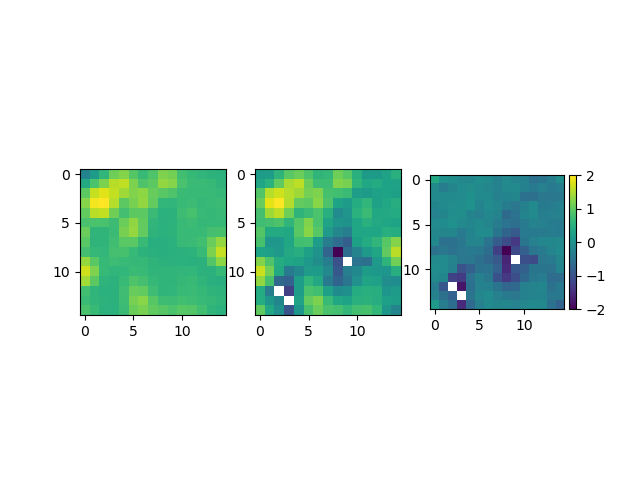

In [61]:
plt.figure()
plt.subplot(131)
plt.imshow(p,vmin=-2,vmax=2)
#plt.colorbar()
plt.subplot(132)
plt.imshow(t,vmin=-2,vmax=2)
#plt.colorbar()

plt.subplot(133)
im = plt.imshow(t-p,vmin=-2,vmax=2)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [48]:
r.x[1]

-6.267217634975543

In [62]:
pt = d*10**r.x[1]

<IPython.core.display.Javascript object>


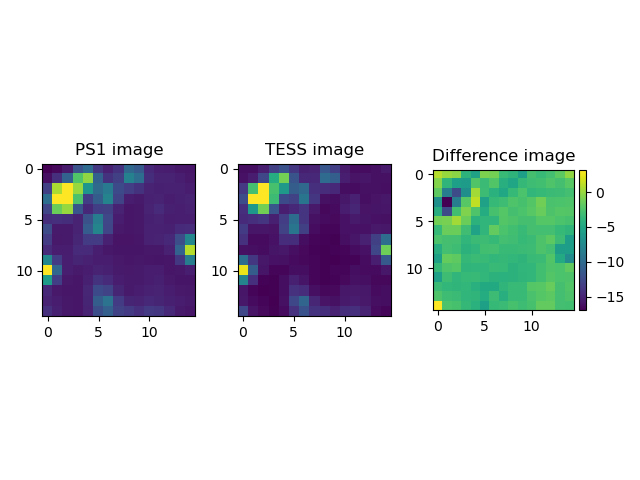

In [84]:
plt.figure()
plt.subplot(131)
plt.title('PS1 image')
plt.imshow(pt,vmax=50)
#plt.colorbar()
plt.subplot(132)
plt.title('TESS image')
plt.imshow(tess,vmax=50)
#plt.colorbar()

plt.subplot(133)
plt.title('Difference image')
im = plt.imshow((tess-pt))

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.tight_layout()
plt.savefig('prf_fit_diffim.png')

<IPython.core.display.Javascript object>


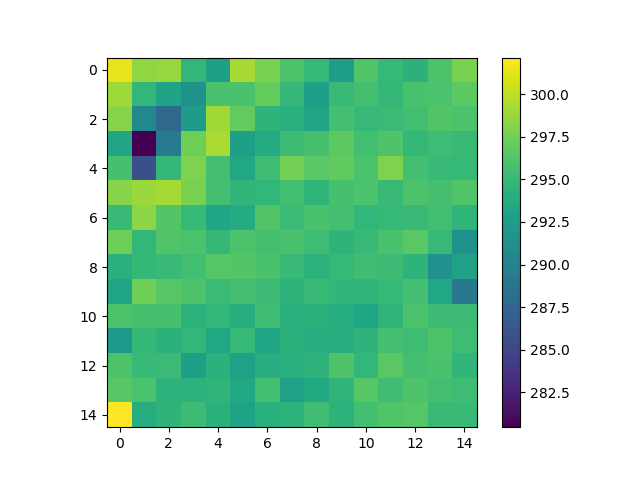

In [72]:
plt.figure()
plt.imshow(tpf.flux[550]-pt)
plt.colorbar()

<IPython.core.display.Javascript object>


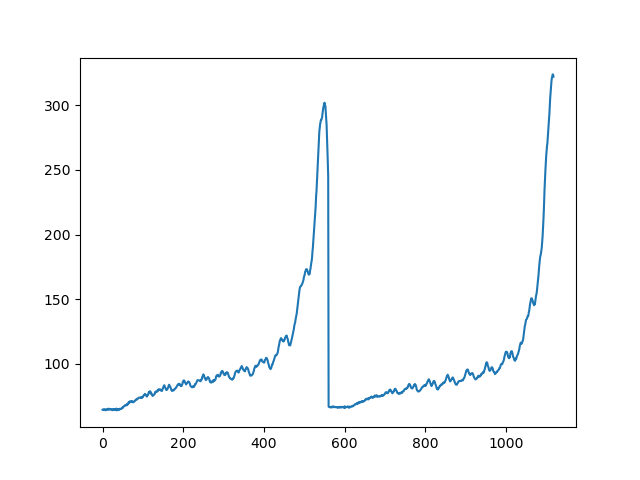

In [71]:
plt.figure()
plt.plot(tpf.flux[:,0,0])

<IPython.core.display.Javascript object>


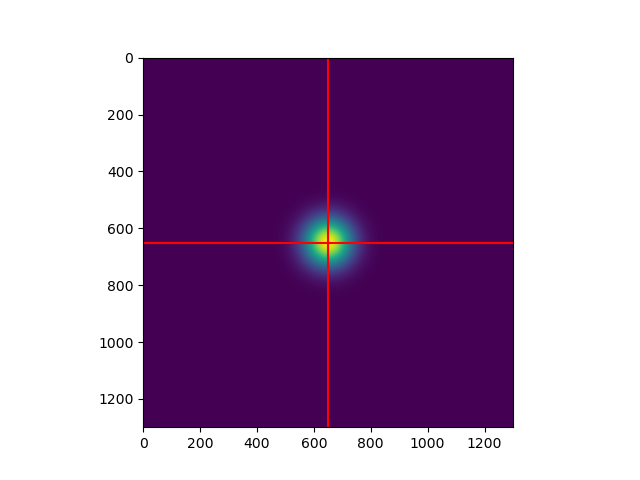

In [37]:
plt.figure()
plt.imshow(g)
plt.axvline(650,color='r')
plt.axhline(650,color='r')

In [ ]:
np.norm

In [9]:
def to_tess_counts(com,z1,z2):
    m = -2.5*np.log10(com) + z1
    f = 10**(-2/5*(m-z2))
    return f

In [10]:
com = to_tess_counts(comp,25,21)
fra = to_tess_counts(frac,25,19.9)

In [24]:
def fit_conv(zp,data,sim):
    d = to_tess_counts(sim,25,10.9)
    data[data<20] = np.nan
    res = np.nansum(abs(np.log10(d)-np.log10(data)))
    print(res)
    return res

eh =tpf.flux[100]-np.percentile(tpf.flux[100],1)
z = minimize(fit_conv,20,args=(eh,frac))

47.23279466099144
47.23279466099144


In [25]:
z

      fun: 47.23279466099144
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([20.])

<IPython.core.display.Javascript object>


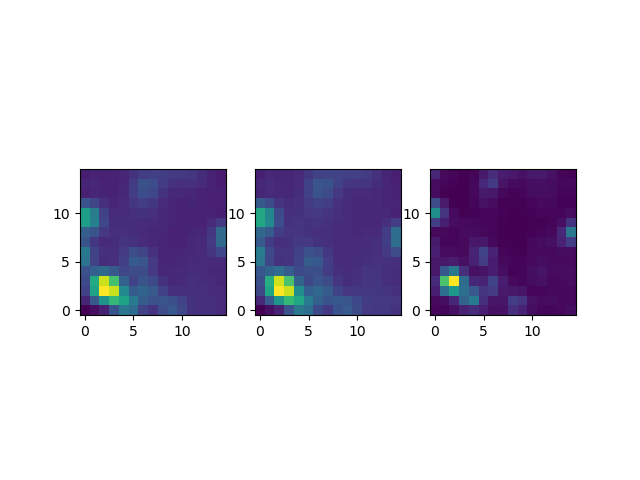

In [11]:

plt.figure()
plt.subplot(131)
plt.imshow(com,origin='lower')
plt.subplot(132)
plt.imshow(fra,origin='lower')
plt.subplot(133)
plt.imshow(tpf.flux[100]-np.percentile(tpf.flux[100],1),origin='lower')

In [12]:
tpf.row

918

In [13]:
tpf.column

1891

In [12]:
test = sd.Catalog_scene(ra,dec,15)

/Users/rridden/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


78


In [18]:
s = np.nansum(test['sources'],axis=0)

<IPython.core.display.Javascript object>


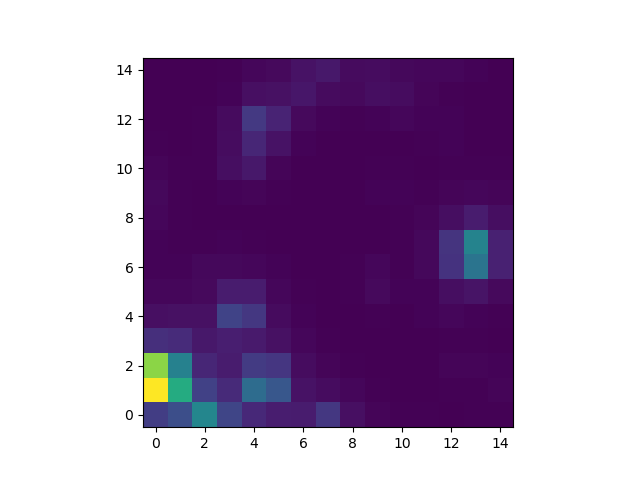

In [20]:
plt.figure()
plt.imshow(s,origin='lower')

<IPython.core.display.Javascript object>


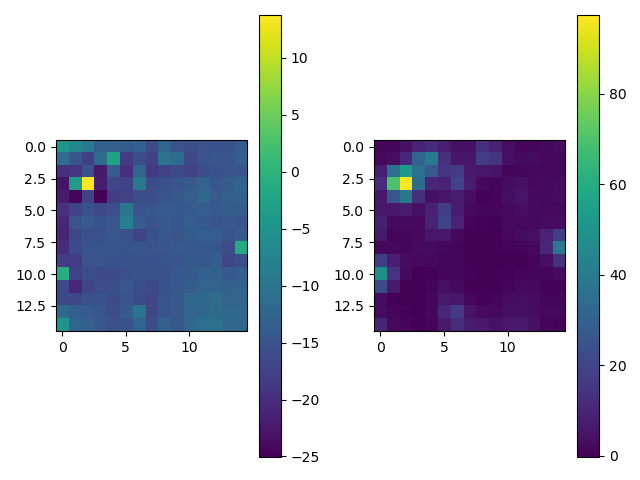

<IPython.core.display.Javascript object>


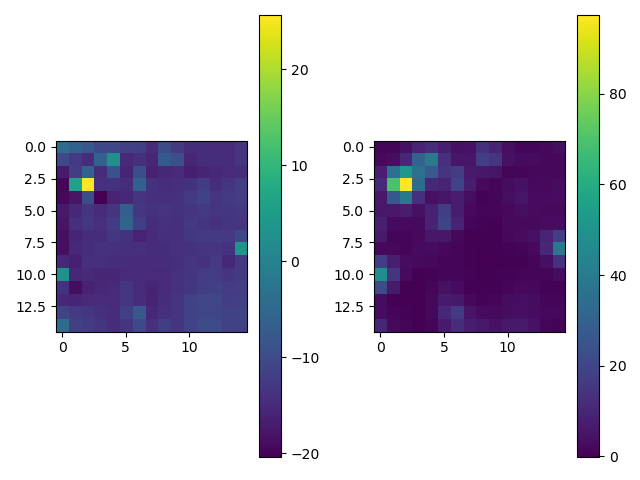

In [30]:
com = to_tess_counts(comp,25,21)
fra = to_tess_counts(frac,25,19.5)
t = tpf.flux[100]-np.percentile(tpf.flux[100],1)
diffcom = t - com
difffra = t - fra
gr = -2.5*np.log10(down['g'])+25 - (-2.5*np.log10(down['r'])+25)
r = -2.5*np.log10(down['r'])+25
plt.figure()
plt.title('Composite image')
plt.subplot(121)
plt.imshow(diffcom)
plt.colorbar()
plt.subplot(122)
plt.imshow(t)
plt.colorbar()
plt.tight_layout()

plt.figure()
plt.title('Filter fraction image')
plt.subplot(121)
plt.imshow(difffra)
plt.colorbar()
plt.subplot(122)
plt.imshow(t)
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


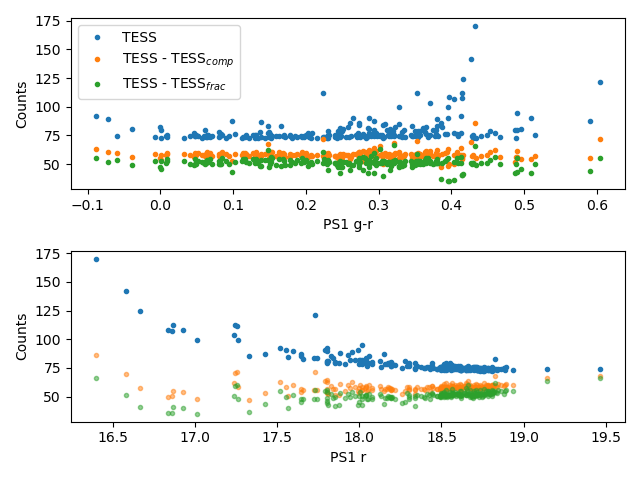

In [158]:
plt.figure()
plt.subplot(211)
plt.plot(gr.flatten(),t.flatten(),'.',label='TESS')
plt.plot(gr.flatten(),diffcom.flatten(),'.',label='TESS - TESS$_{comp}$')
plt.plot(gr.flatten(),difffra.flatten(),'.',label='TESS - TESS$_{frac}$')
plt.xlabel('PS1 g-r')
plt.ylabel('Counts')
plt.legend()

plt.subplot(212)
plt.plot(r.flatten(),t.flatten(),'.',label='TESS')
plt.plot(r.flatten(),diffcom.flatten(),'.',color='C1',alpha=.5,label='TESS - TESS$_{comp}$')
plt.plot(r.flatten(),difffra.flatten(),'.',color='C2',alpha=.5,label='TESS - TESS$_{frac}$')
plt.xlabel('PS1 r')
plt.ylabel('Counts')
#plt.legend()
plt.tight_layout()
plt.savefig('tess_ps1_difference.png')
#plt.savefig('tess_ps1_difference.png')

<IPython.core.display.Javascript object>


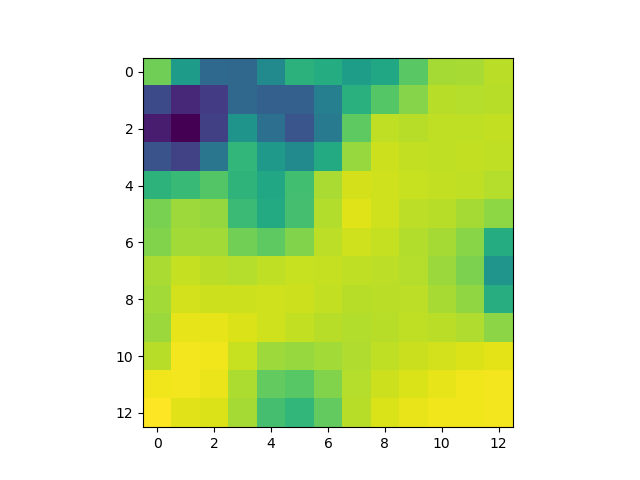

In [53]:
plt.figure()
plt.imshow(-2.5*np.log10(down['g'])+25)

In [27]:
def Combine_PS1(coeff,ps1):
    g = ps1['g']#/100
    r = ps1['r']#/100
    i = ps1['i']#/100
    z = ps1['z']#/100
    y = ps1['y']#/100
    
    com = (coeff[0]*g + coeff[1]*r + coeff[2]*i + coeff[3]*z + coeff[4]*y)*(g/i)**coeff[5] + coeff[6]
    
    return com

def minimiser(c,ps1,tess):
    #print(c)
    z= -2.5*np.log10(ps1['z']) + 25 
    tess[tess<=0] = np.nan
    t = -2.5*np.log10(tess) + 20.44
    com = Combine_PS1(c,ps1)
    
    m = -2.5*np.log10(com) + 25
    m[(z>20) | (~np.isfinite(m))] = np.nan
    if np.nansum(m) ==0:
        return np.inf
    diff = abs(m-t)
    #plt.figure()
    gr = -2.5*np.log10(ps1['g']) + 2.5*np.log10(ps1['r'])
    
    #plt.subplot(121)
    #plt.plot(gr.flatten(),diff.flatten(),'.')
    #plt.subplot(122)
    #plt.plot(g.flatten(),diff.flatten(),'.')
    #plt.colorbar()
    res = np.nansum(diff)
    print(res)

    return res

In [28]:
tess = tpf.flux[0]
tess = tess - np.percentile(tess,1)

c0 = [.25,.25,.25,.25,.25,0.1,100]
bds = [(0,1),(0,1),(0,1),(0,1),(0,1),(-10,10),(0,100)]
res = minimize(minimiser,c0,args=(down,tess),bounds=bds)

180.74026790336166
180.74026830537122
180.74026840542624
180.74026841441773
180.74026881901187
180.74026979952941
180.74026765342637
180.74026790220307
189.02017069168238
189.02016787301537
189.02016799269214
189.02016823946408
189.02016723404859
189.02016515458095
189.02017069168238
189.02017068081213
158.49499311289657
158.49499313286236
158.4949930959424
158.49499302168908
158.49499314342387
158.4949934721625
158.49499321701575
158.49499310991038
131.21746568752022
131.21746534083388
131.2174652223353
131.2174650900944
131.21746504649568
131.21746505432225
131.21746581416335
131.21746568451866
459.5542895346196
459.5542906792245
459.55429103483743
459.5542911287341
459.5542923284895
459.55429523575043
459.5542891173686
459.55428953408085
108.89401604218405
108.89401590732339
108.89401583347096
108.89401569006579
108.89401589132993
108.89401651794596
108.89401616394214
108.89401604184856
207.6184284978815
207.61842972053182
207.61843011952396
207.6184302211674
207.6184315093406
207.6

In [29]:
res.x

array([ 1.07539559e-02,  0.00000000e+00,  1.74069484e-01,  0.00000000e+00,
        0.00000000e+00, -3.24966164e+00,  9.99902054e+01])

In [34]:
com = Combine_PS1(res.x,down)
c = -2.5*np.log10(com) + 25

b = -2.5*np.log10(down['i']) + 25
b[~np.isfinite(b)] = 21

<IPython.core.display.Javascript object>


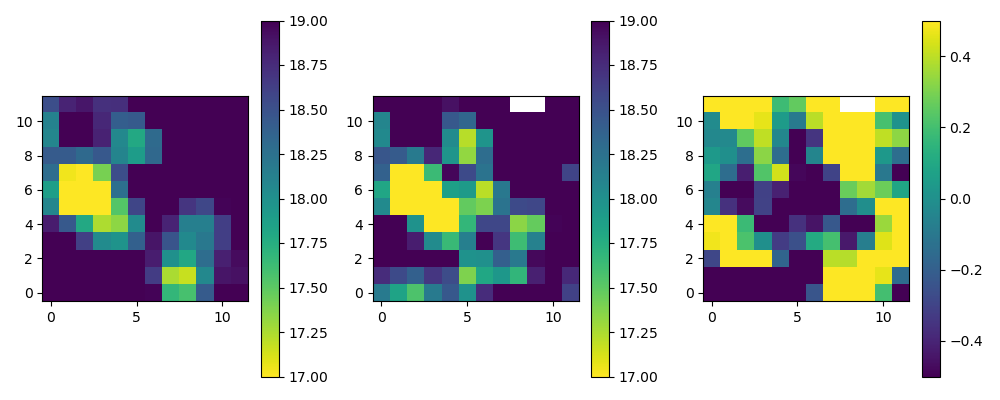

In [35]:
t = -2.5*np.log10(tess)+20.44
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(c,cmap='viridis_r',vmax=19,vmin=17,origin='lower')
plt.colorbar()
plt.subplot(132)
plt.imshow(t,cmap='viridis_r',vmax=19,vmin=17,origin='lower')
plt.colorbar()

plt.subplot(133)
plt.imshow(t-c,origin='lower',vmin=-.5,vmax=.5)
plt.colorbar()
plt.tight_layout()

/Users/rridden/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


<IPython.core.display.Javascript object>


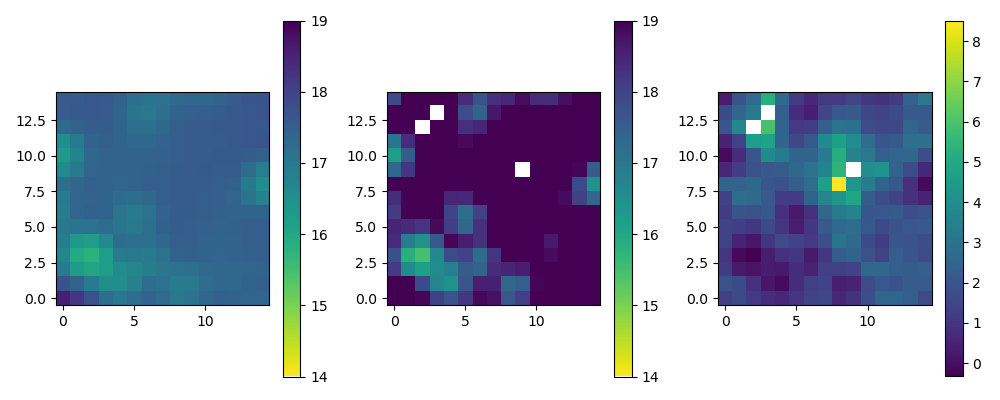

In [31]:
f = -2.5*np.log10(fra-np.percentile(t,1)) + 20.44
tt = -2.5*np.log10(t-np.percentile(t,1))+20.44 
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.imshow(f,cmap='viridis_r',vmax=19,vmin=14,origin='lower')
plt.colorbar()
plt.subplot(132)
plt.imshow(tt,cmap='viridis_r',vmax=19,vmin=14,origin='lower')
plt.colorbar()

plt.subplot(133)
plt.imshow(tt-f,origin='lower')
plt.colorbar()
plt.tight_layout()